In [9]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from ignite.metrics import SSIM

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

mode = 'test'

Using cuda:0 device


In [11]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        )
        self.residual1 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=25, stride=1, padding=12),
            nn.LeakyReLU()
        )
        self.residual2 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU()
        )
        
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        residual1 = self.residual1(x)
        block3 = self.block3(block2 + residual1)
        pixelshuffle = nn.PixelShuffle(2)
        residual2 = self.residual2(x)
        block4 = self.block4(pixelshuffle(block3) + pixelshuffle(residual2))
        return block4



In [12]:
generator = Generator().to(device)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)
generator_loss = nn.MSELoss()

In [13]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def load_images_from_folder(folder):
    images = []
    files = os.listdir(folder)
    for i in range(1254):
        img = cv2.cvtColor(cv2.imread(os.path.join(folder, files[i])), cv2.COLOR_BGR2RGB)
        img = torch.from_numpy(np.asarray(img))
        img = img.permute(2, 0, 1)
        images.append(img / 255)
    return torch.from_numpy(np.asarray(images))


high_res_loaded = load_images_from_folder('../dataset')
high_res_images = nn.functional.interpolate(high_res_loaded, scale_factor=1/4, mode='bilinear')
low_res_images = nn.functional.interpolate(high_res_images, scale_factor=1/2, mode='bilinear')
dataset = TensorDataset(low_res_images, high_res_images)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [14]:
num_epochs = 40
# ssim = SSIM(data_range=1)

if mode == 'train':
    for epoch in range(num_epochs):
        for i, (low_res, high_res) in enumerate(dataloader):
            high_res_real = high_res.to(device)
            low_res = low_res.to(device)

            gen_hr = generator(low_res)

            # ssim.update([gen_hr, high_res_real])
            # new_ssim_val = ssim.compute()
            gen_hr_loss = generator_loss(gen_hr, high_res_real)

            generator_optimizer.zero_grad()
            gen_hr_loss.backward()
            generator_optimizer.step()

            # ssim.reset()

            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
                    f"[G loss: {gen_hr_loss.item():.6f}]")
            

In [15]:
if mode == 'train':
    torch.save(generator.state_dict(), './srcnn.pth')

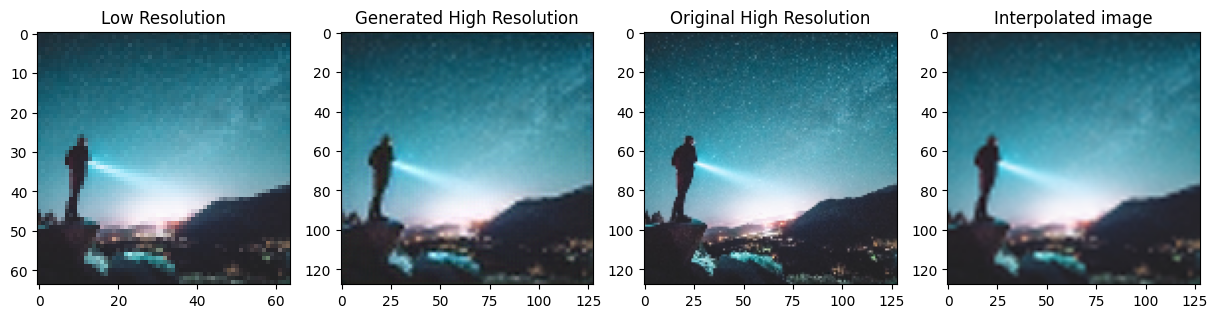

In [37]:
generator.load_state_dict(torch.load('./srcnn.pth'))

def tensor_to_image(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = (image * 255).clip(0, 255).astype("uint8")
    return image


def compare_img(number):
    img = cv2.cvtColor(cv2.imread(os.path.join(f'../dataset/{number}.jpg')), cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(np.asarray(img)) / 255
    img = img.permute(2, 0, 1)
    high_res_real = torch.from_numpy(np.array([img])).to(device)
    high_res_out = nn.functional.interpolate(high_res_real, scale_factor=0.25, mode='bilinear')
    low_res = nn.functional.interpolate(high_res_out, scale_factor=1/2, mode='bilinear')
    interpolated = nn.functional.interpolate(low_res, scale_factor=2, mode='bicubic')

    generator.eval()
    with torch.no_grad():
        gen_hr = generator(low_res)

    low_res_img = tensor_to_image(low_res.squeeze(0))
    gen_hr_img = tensor_to_image(gen_hr.squeeze(0))
    high_res_img = tensor_to_image(high_res_out[0])
    interpolated_img = tensor_to_image(interpolated[0])


    fig, axs = plt.subplots(1, 4, figsize=(15, 5))

    axs[0].imshow(low_res_img)
    axs[0].set_title('Low Resolution')

    axs[1].imshow(gen_hr_img)
    axs[1].set_title('Generated High Resolution')

    axs[2].imshow(high_res_img)
    axs[2].set_title('Original High Resolution')

    axs[3].imshow(interpolated_img)
    axs[3].set_title('Interpolated image')


compare_img(567)
# plt.show()